### Libraries

In [39]:
# General Imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
import yaml
import numpy as np
from glob import glob
import time 
import cv2


# Tensorflow Imports
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Dense, Lambda, Input, Dense
from tensorflow.keras.layers import MaxPooling2D, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import SeparableConv2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
print(f"TensorFlow version: {tf.__version__}")

# Local Module Imports
sys.path.append("../src")  # adds source code directory
from utils import load_images_from_folder, label_to_frame, frame_to_label
from utils import frames_to_video, save_history
from visualization import plot_learning_curves
from polygon_handle import masks_to_polygons
from log_setup import logger

TensorFlow version: 2.15.0


### Directories

In [40]:
current_dir = os.getcwd()
BASE_DIR = os.path.dirname(current_dir)
dataset_dir = os.path.join(BASE_DIR, "dataset")
data_dir = os.path.join(BASE_DIR, "data")
config_file = os.path.join(BASE_DIR, "config.yml")


# Operation Mode
DATA = "full"  # "full" or "sampled" or "reg_sampled"
MODE = "extrapol"  # "interpol" or "extrapol"
MODEL = "CVAE"  
PERCENTAGE = 90 

# Output PNG directory
if MODE == "extrapol":
    output_dir = os.path.join(BASE_DIR, 'outputs', 'CVAE', MODE, str(PERCENTAGE), DATA)
    logger.info(f"Data: {DATA}, Mode: {MODE}, Model: {MODEL} Percentage: {PERCENTAGE}%,\nOutput directory: {output_dir}")
elif MODE == "interpol":
    output_dir = os.path.join(BASE_DIR, 'outputs', 'CVAE', MODE, DATA)
    logger.info(f"Data: {DATA}, Mode: {MODE}, Model: {MODEL}\nOutput directory: {output_dir}")

INFO - Data: full, Mode: extrapol, Model: CVAE Percentage: 90%,
Output directory: /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/outputs/CVAE/extrapol/90/full


### Config file

In [41]:
with open(config_file, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

### Data loading

In [42]:
# reconstruct the masks labels
train_masks_dir = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
test_masks_dir = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")
sampled_masks_txt_path = os.path.join(BASE_DIR, config["data"]["sampled_masks_txt"])
with open(sampled_masks_txt_path, "r", encoding="utf-8") as f:
    polygons = f.readlines()
    # extract indexes
    indexes = [int(polygon.split(",")[0]) for polygon in polygons]

train_sampled_masks_dir = os.path.join(
    BASE_DIR, config["data"]["train_sampled_dir"], "masks"
)

msks_train_paths = sorted(glob(os.path.join(train_masks_dir, "*.png")))
msks_train_labels = [
    int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 for m in msks_train_paths
]
msks_test_paths = sorted(glob(os.path.join(test_masks_dir, "*.png")))
msks_test_labels = [
    int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 + 20250
    for m in msks_test_paths
]
msks_train_sampled_paths = sorted(glob(os.path.join(train_sampled_masks_dir, "*.png")))
msks_train_sampled_labels = [100 * i for i in indexes]

print(
    f"Masks || Train: {len(msks_train_paths)}, Train sampled: {len(msks_train_sampled_paths)} | Test: {len(msks_test_paths)} |"
)

Masks || Train: 226, Train sampled: 13 | Test: 23 |


In [43]:
if DATA == "full":
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
    train_masks = load_images_from_folder(
        TRAIN_DIR, target_size=config["data"]["input_size"][:2]
    )
    # labels normalization and reshaping
    max_val = np.max(msks_train_labels)
    train_labels = (msks_train_labels / max_val).astype(np.float32)
    train_labels = np.expand_dims(train_labels, axis=-1)
else:
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_sampled_dir"], "masks")
    train_masks = load_images_from_folder(
        TRAIN_DIR, target_size=config["data"]["input_size"][:2]
    )
    # labels normalization and reshaping
    max_val = np.max(msks_train_labels)
    train_labels = (msks_train_sampled_labels / max_val).astype(np.float32)
    train_labels = np.expand_dims(train_labels, axis=-1)

if MODE == "extrapol":  # truncate the train set to aprox. 90% of the original size
    train_masks = train_masks[: int(PERCENTAGE/100 * len(train_masks))]
    train_labels = train_labels[: int(PERCENTAGE/100 * len(train_labels))]
    # print each label number with label_to_frame
    print("\nTruncated training labels:", end=' ')
    for i in range(len(train_labels)):
        print(label_to_frame(train_labels[i], max_val), end=', ')
    print(f"| Total No. of labels: {len(train_labels)}\n")


TEST_DIR = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")
test_masks = load_images_from_folder(
    TEST_DIR, target_size=config["data"]["input_size"][:2]
)
test_labels = (msks_test_labels / max_val).astype(np.float32)
test_labels = np.expand_dims(test_labels, axis=-1)

print("-" * 58)
print(f"{'Variable':<15} {'Shape (N,H,W,C)':<18} {'Dtype':<9} {'Max':<7} {'Min':<8}")
print("-" * 58)
print(
    f"{'train_imgs':<15} {str(train_masks.shape):<18} {str(train_masks.dtype):<8}  {np.max(train_masks):.1f}    {np.min(train_masks):.1f}"
)
print(
    f"{'train_labels':<15} {str(train_labels.shape):<18} {str(train_labels.dtype):<8}  {np.max(train_labels):.1f}     {np.min(train_labels):.1f}"
)
print("~" * 58)
print(
    f"{'test_imgs':<15} {str(test_masks.shape):<18} {str(test_masks.dtype):<8}  {np.max(test_masks):.1f}    {np.min(test_masks):.1f}"
)
print(
    f"{'test_labels':<15} {str(test_labels.shape):<18} {str(test_labels.dtype):<8}  {np.max(test_labels):.1f}     {np.min(test_labels):.1f}"
)
print("-" * 58)


Truncated training labels: 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1899, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3299, 3400, 3500, 3600, 3700, 3799, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6599, 6700, 6800, 6900, 7000, 7099, 7200, 7300, 7400, 7500, 7599, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12699, 12800, 12900, 13000, 13100, 13199, 13300, 13400, 13500, 13600, 13699, 13800, 13900, 14000, 14100, 14199, 14300, 14400, 14500, 14600, 14699, 14800, 14900, 15000, 15100, 15199, 15300, 15400,

### C-VAE definition

In [44]:
def deconv_block(input, filters, f_init="he_normal"):
    """
    Apply two convolutional layers with ReLU activation function.

    Args:
        input (tensor): Input tensor to the block.
        filters (int): Number of filters in the convolutional layers.

    Returns:
        tensor: Output tensor of the block with ReLU activation.
    """
    x = Conv2DTranspose(
        filters,
        kernel_size=(4, 4),
        strides=2,
        kernel_initializer=f_init,
        data_format="channels_last",
        padding="same",
    )(input)

    x = SeparableConv2D(
        filters,
        kernel_size=(4, 4),
        depthwise_initializer=f_init,
        pointwise_initializer=f_init,
        padding="same",
    )(x)
    x = Activation(tf.nn.leaky_relu)(x)

    x = SeparableConv2D(
        filters,
        kernel_size=(4, 4),
        depthwise_initializer=f_init,
        pointwise_initializer=f_init,
        padding="same",
    )(x)
    activation = Activation(tf.nn.leaky_relu)(x)

    return activation

def conv_block(input, filters, f_init="he_normal"):
    """
    Apply two convolutional layers with ReLU activation function.

    Args:
        input (tensor): Input tensor to the block.
        filters (int): Number of filters in the convolutional layers.

    Returns:
        tensor: Output tensor of the block with ReLU activation.
    """
    x = SeparableConv2D(
        filters,
        kernel_size=(4, 4),
        depthwise_initializer=f_init,
        pointwise_initializer=f_init,
        padding="same",
    )(input)
    x = Activation(tf.nn.leaky_relu)(x)

    x = SeparableConv2D(
        filters,
        kernel_size=(4, 4),
        depthwise_initializer=f_init,
        pointwise_initializer=f_init,
        padding="same",
    )(x)
    ativ = Activation(tf.nn.leaky_relu)(x)

    m_pool = MaxPooling2D(
        pool_size=(2, 2), strides=2, data_format="channels_last", padding="same"
    )(ativ)

    return m_pool

def sampler(args):
    """
    Reparameterization trick by sampling fr an isotropic unit Gaussian.
    
    Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def mse_kl_loss(y_true, y_pred, beta: float = 1.0):
    """Calculate loss = reconstruction loss + KL loss for each data in minibatch"""
    # E[log P(X|z)]
    squared_difference = tf.square(y_true - y_pred)
    reconstruction = tf.reduce_mean(squared_difference, axis=-1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed from as both dist. are Gaussian
    kl_divergence = 0.5 * tf.reduce_sum(
        tf.exp(z_log_var) + tf.square(z_mean) - 1.0 - z_log_var, axis=-1
    )
    return reconstruction + beta * kl_divergence

In [45]:
H, W, C = config["data"]["input_size"]

# --------
# Encoder
# --------

encoder_inputs = Input(shape=(H, W, C))
# Reshape input to 2D image

x = conv_block(
    encoder_inputs, config["CVAE"]["ref_filters"] * 2, config["CVAE"]["w_init"]
)
x = conv_block(x, config["CVAE"]["ref_filters"] * 1, config["CVAE"]["w_init"])
x = Flatten()(x)
x = Dense(64, activation="leaky_relu")(x)

# VAE specific layers for mean and log variance
z_mean = Dense(config["CVAE"]["latent_dim"], activation="leaky_relu", name="z_mean")(x)
z_log_var = Dense(
    config["CVAE"]["latent_dim"], activation="leaky_relu", name="z_log_var"
)(x)

# Sampling layer to sample z from the latent space
z = Lambda(sampler, output_shape=(config["CVAE"]["latent_dim"],), name="z")(
    [z_mean, z_log_var]
)

# Instantiate encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --------
# Decoder
# --------

latent_inputs = Input(shape=(config["CVAE"]["latent_dim"],), name="z_sampling")
label_size = len(train_labels[0])
label_inputs = Input(shape=(label_size,), name="label")
decoder_inputs = Concatenate()([latent_inputs, label_inputs])
x = Dense(64 * 64 * 64, activation="leaky_relu")(decoder_inputs)
x = Reshape((128, 128, 16))(x)
x = deconv_block(x, config["CVAE"]["ref_filters"] * 2, config["CVAE"]["w_init"])
x = deconv_block(x, config["CVAE"]["ref_filters"] * 4, config["CVAE"]["w_init"])
decoder_output = Conv2DTranspose(1, 3, activation="tanh", padding="same")(x)

decoder = Model([latent_inputs, label_inputs], decoder_output, name="decoder")

# -----------------
# Conditional VAE
# -----------------

outputs = decoder([encoder(encoder_inputs)[2], label_inputs])
cvae = Model([encoder_inputs, label_inputs], outputs, name="cvae")
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64),                 3357281   ['input_3[0][0]']             
                              (None, 64),                 6                                       
                              (None, 64)]                                                         
                                                                                                  
 label (InputLayer)          [(None, 1)]                  0         []                            
                                                                                               

### Callbacks

In [46]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss", 
    factor=0.5, 
    mode="min",
    patience=30, 
    verbose=1, 
    min_lr=1e-8
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=40,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

checkpoint_dir = os.path.join(BASE_DIR, config["data"]["checkpoint_dir"])
if MODE == "extrapol":
    checkpoint_filepath = os.path.join(
        checkpoint_dir, f"cvae_{DATA}_{MODE}_{PERCENTAGE}.h5"
    )
elif MODE == "interpol":
    checkpoint_filepath = os.path.join(checkpoint_dir, f"cvae_{DATA}_{MODE}.h5")

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    mode="auto",
    verbose=1,
    monitor="loss",
)

cvae.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=config["CVAE"]["learning_rate"]
    ),
    loss=mse_kl_loss,
)

### Training

In [47]:
cvae.optimizer.lr = config["CVAE"]["learning_rate"]

history = cvae.fit(
    [train_masks, train_labels],
    train_masks,
    epochs=config["CVAE"]["epochs"],
    batch_size=1,
    validation_data=([test_masks, test_labels], test_masks),
    callbacks=[reduce_lr, checkpoint, early_stopping],
)

Train on 203 samples, validate on 23 samples
Epoch 1/500
203/203 [==============================] - ETA: 0s - loss: 0.6681
Epoch 1: loss improved from inf to 0.66810, saving model to /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/checkpoints/cvae_full_extrapol_90.h5
203/203 [==============================] - 27s 129ms/sample - loss: 0.6681 - val_loss: 0.4421 - lr: 3.0000e-04
Epoch 2/500
203/203 [==============================] - ETA: 0s - loss: 0.2661
Epoch 2: loss improved from 0.66810 to 0.26609, saving model to /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/checkpoints/cvae_full_extrapol_90.h5
203/203 [==============================] - 26s 129ms/sample - loss: 0.2661 - val_loss: 0.4380 - lr: 3.0000e-04
Epoch 3/500
203/203 [==============================] - ETA: 0s - loss: 0.2371
Epoch 3: loss improved from 0.26609 to 0.23711, saving model to /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/checkpoints/cvae_full_extrapol_90.h5
203/203 [===========

Saved history to /home/tiagociic/Projectos/spatiotemporal-vae-reconstruction/checkpoints/history_sampled_extrapol_90.csv


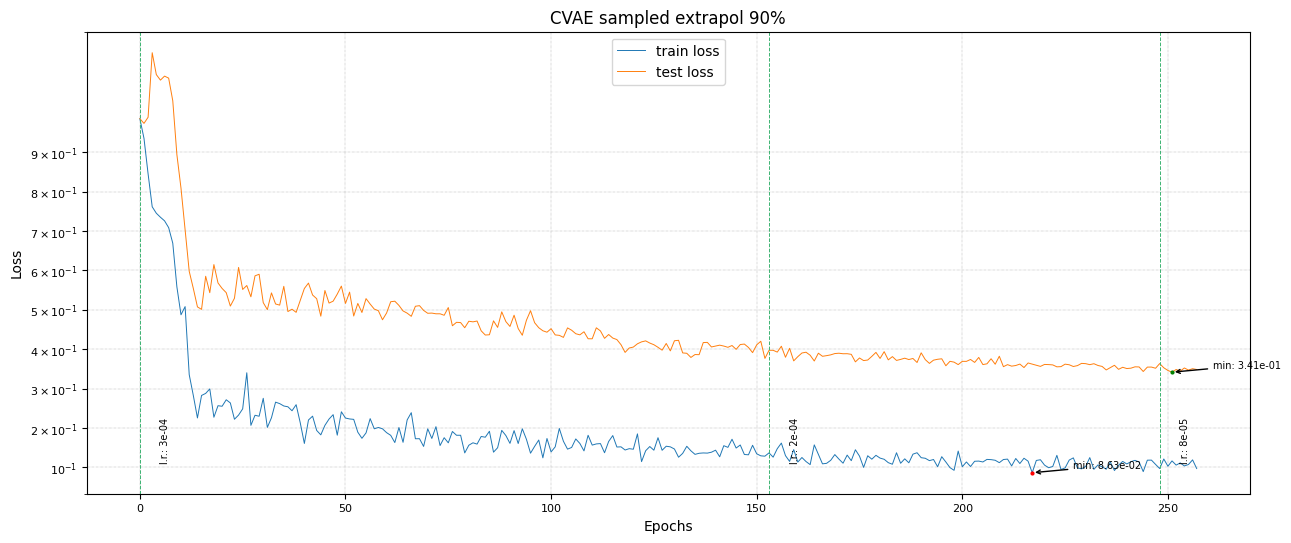

In [ ]:
# plot and save learning curves
if MODE == "extrapol":
    save_history(history, os.path.join(checkpoint_dir, f"history_{DATA}_{MODE}_{PERCENTAGE}.csv"))
    # plot_learning_curves(history, log_scale=True,plt_title=f"CVAE {DATA} {MODE} {PERCENTAGE}%", save_fig = True)
    plot_learning_curves(history, log_scale=True,plt_title=f"CVAE {DATA} {MODE} {PERCENTAGE}%")
elif MODE == "interpol":
    save_history(history, os.path.join(checkpoint_dir, f"history_{DATA}_{MODE}.csv"))
    # plot_learning_curves(history, log_scale=True,plt_title=f"CVAE {DATA} {MODE}", save_fig = True)
    plot_learning_curves(history, log_scale=True,plt_title=f"CVAE {DATA} {MODE}")

### Inference

In [ ]:
# load the best model
cvae.load_weights(checkpoint_filepath)

In [ ]:
def generate_frames(
    decoder, output_dir: str, total_frames: int = 22500, resize_original: bool = False
):
    """
    Generates and saves the frames from a trained decoder.

    Parameters:
        decoder (keras.Model): The trained decoder.
        output_dir (str): The path to the output directory.
        total_frames (int): The total number of frames to generate.
        resize_original (bool): Whether to resize the frames to the original dimensions.
    """

    start_total_time = time.time()

    frames_num = np.arange(1, total_frames + 1, 1)

    for i in range(total_frames):
        frame_num = frames_num[i]

        # Sample from the latent space
        z_sample = np.full((1, config["CVAE"]["latent_dim"]), 0.5)

        # Generate the frame
        try:
            start_time = time.time()
            reconst = decoder.predict([z_sample, frame_to_label(frame_num)])
            reconst_time = (time.time() - start_time) * 1000
            reconst = np.squeeze(reconst, axis=0)
        except Exception as e:
            print(f"Error generating frame {frame_num}: {e}")
            continue

        if resize_original:
            start_time = time.time()
            reconst = tf.image.resize(
                images=reconst, size=config["data"]["original_vid_dims"]
            )
            resize_time = (time.time() - start_time) * 1000
        else:
            resize_time = 0.0  # Not resizing

        # Binarize the reconstructed image with OpenCV
        start_time = time.time()
        _, thresh_img = cv2.threshold(
            reconst, config["CVAE"]["threshold"], 255, cv2.THRESH_BINARY
        )
        threshold_time = (time.time() - start_time) * 1000

        # Save the thresholded image as png in grayscale
        try:
            start_time = time.time()
            cv2.imwrite(
                os.path.join(output_dir, f"frame_{frame_num:06d}.png"), thresh_img
            )
            save_time = (time.time() - start_time) * 1000
        except Exception as e:
            print(f"Error saving frame {frame_num}: {e}")
            continue

        # Print progress with time information
        print(
            f"Generated frame {i+1} of {total_frames} | "
            f"Reconst: {reconst_time:.2f}ms | "
            f"Resize: {resize_time:.2f}ms | "
            f"Threshold: {threshold_time:.2f}ms | "
            f"Save: {save_time:.2f}ms | "
            f"Elapsed Time: {time.time() - start_total_time:.2f}s  ",
            end="\r",
        )
    print()

In [ ]:
output_png_dir = os.path.join(output_dir, "PNG")
generate_frames(decoder, output_png_dir)

Generated frame 22500 of 22500 | Reconst: 24.69ms | Resize: 0.00ms | Threshold: 0.11ms | Save: 1.09ms | Elapsed Time: 553.15s  


In [ ]:
# generate video from the generated frames
if MODE == "extrapol":
    file_name = f"video_{DATA}_{MODE}_{PERCENTAGE}"
    title = f"CVAE: {MODE}ation - {DATA}, {PERCENTAGE}, {config['CVAE']['epochs']} epochs, 10x speed"
elif MODE == "interpol":
    file_name = f"video_{DATA}_{MODE}"
    title = f"CVAE: {MODE}ation - {DATA}, {config['CVAE']['epochs']} epochs, 10x speed"

frames_to_video(
    img_list_dir=os.path.join(output_dir, "PNG"),
    output_dir=output_dir,
    output_resolution=config["data"]["original_vid_dims"],
    title=title,
    f_ps=250, # 10x speed
    file_name=file_name,
    frame_num_text=True,
    font_size=1,
)

INFO - Creating image list...                          
INFO - Writing frames to file 1/22500
INFO - Writing frames to file 1001/22500
INFO - Writing frames to file 2001/22500
INFO - Writing frames to file 3001/22500
INFO - Writing frames to file 4001/22500
INFO - Writing frames to file 5001/22500
INFO - Writing frames to file 6001/22500
INFO - Writing frames to file 7001/22500
INFO - Writing frames to file 8001/22500
INFO - Writing frames to file 9001/22500
INFO - Writing frames to file 10001/22500
INFO - Writing frames to file 11001/22500
INFO - Writing frames to file 12001/22500
INFO - Writing frames to file 13001/22500
INFO - Writing frames to file 14001/22500
INFO - Writing frames to file 15001/22500
INFO - Writing frames to file 16001/22500
INFO - Writing frames to file 17001/22500
INFO - Writing frames to file 18001/22500
INFO - Writing frames to file 19001/22500
INFO - Writing frames to file 20001/22500
INFO - Writing frames to file 21001/22500
INFO - Writing frames to file 220

In [12]:
# List of generated frames paths
msks_paths = sorted(glob(os.path.join(output_png_dir, "*.png")))

# Convert the masks to polygons and save them as a WKT file
polygons = masks_to_polygons(
    msks_paths,
    out_dim=tuple(config["data"]["original_vid_dims"]),
    save_path=os.path.join(BASE_DIR, MODEL, MODE, DATA, "WKT", f"{MODE}_{DATA}.wkt"),
),

/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/rasterio/features.py:126: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  for s, v in _shapes(source, mask, connectivity, transform):
/home/tiagociic/miniconda3/envs/cvae/lib/python3.10/site-packages/rasterio/features.py:126: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  for s, v in _shapes(source, mask, connectivity, transform):


KeyboardInterrupt: 

In [11]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Value
from multiprocessing import cpu_count
from time import sleep
from os import cpu_count
from time import time
from functools import partial
import cv2
import time
import numpy as np
from rasterio.features import shapes
from rasterio import Affine
from shapely.geometry import shape, MultiPolygon
from IPython.display import clear_output


def resize_image(img_path, counter, out_dim=(512, 512)):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        h, w = img.shape
        if (w, h) != out_dim:
            img = cv2.resize(img, out_dim, interpolation=cv2.INTER_CUBIC)
        return mask_to_poly(img)
    except Exception as e:
        logger.ERROR(f"Error processing {img_path}: {e}")
    finally:
        with counter.get_lock():
            counter.value += 1
        

from concurrent.futures import as_completed

def masks_to_polygons_v2(msks_paths: list, out_dim: tuple = (512, 512), save_path: str = None) -> list:
    start_time = time.time()
    counter = Value('i', 0)

    with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
        futures = {executor.submit(resize_image, img_path, counter, out_dim): img_path for img_path in msks_paths}

    # Collect results in order
    pol_list = []
    for future in as_completed(futures):
        pol_list.append(future.result())
        
        # Print progress
        with counter.get_lock():
            counter.value += 1
            print(f"Processed {counter.value} masks", end="\r", flush=True)

    elapsed_time = time.time() - start_time
    print(f"\nProcessed {len(msks_paths)} masks | Time elapsed: {elapsed_time:.2f}s")
    clear_output(wait=True)

    if save_path:
        save_polygons_to_wkt(pol_list, save_path)
        logger.info(f"Saved polygons to {save_path}")

    return pol_list



def save_polygons_to_wkt(polygon_list: list, file_path: str) -> None:
    """
    Save a list of shapely polygons to a WKT format file.

    Parameters:
    polygon_list (list): List of shapely polygons.
    file_path (str): Path to the output file.
    """
    with open(file_path, "w") as f:
        for polygon in polygon_list:
            f.write(polygon.wkt + "\n")


def mask_to_poly(mask_img: np.ndarray) -> MultiPolygon:
    """
    Converts a segmentation mask to a shapely multipolygon.

    Parameters:
    mask_img (numpy.ndarray): The segmentation mask.

    Returns:
    shapely.geometry.MultiPolygon: The shapely multipolygon.
    """
    start_time = time.time()

    all_polygons = list()

    for shp, _ in shapes(
        source=mask_img.astype(np.uint8),
        mask=(mask_img > 0),
        transform=Affine(1.0, 0, 0, 0, 1.0, 0),
    ):
        all_polygons.append(shape(shp))

    all_polygons = MultiPolygon(all_polygons)

    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        if all_polygons.geom_type == "Polygon":
            all_polygons = MultiPolygon([all_polygons])

    end_time = time.time()
    elapsed_time = end_time - start_time
    logger.debug(f"mask_to_poly elapsed time: {elapsed_time:.2f} seconds  ", end='\r')

    return all_polygons
